# **Intelligent Forensic Survey of Vehicular Motion and Impact Zones Using Aerial Imagery**

**Part 1: Vehicle Tracking and Speed Detection**

**Video Playback**

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Path to your video
video_path = './inputVideo/highway.mp4'

# Open the video file
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise IOError("Cannot open video file")

# Get FPS for optional delay (real-time playback)
fps = cap.get(cv2.CAP_PROP_FPS)
delay = int(1000 / fps)

# Read and display frames
while True:
    ret, frame = cap.read()
    if not ret:
        break

    cv2.imshow("Video Playback", frame)

    # Press 'q' to quit
    if cv2.waitKey(delay) & 0xFF == ord('q'):
        break

# Cleanup
cap.release()
cv2.destroyAllWindows()


In [9]:
!pip install opencv-python
!pip install opencv-contrib-python


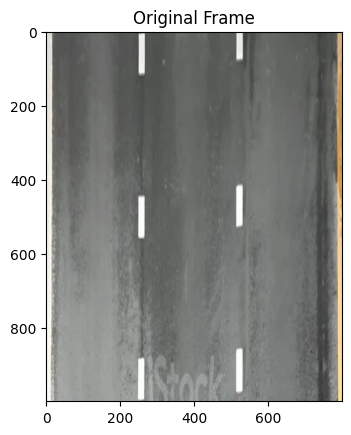

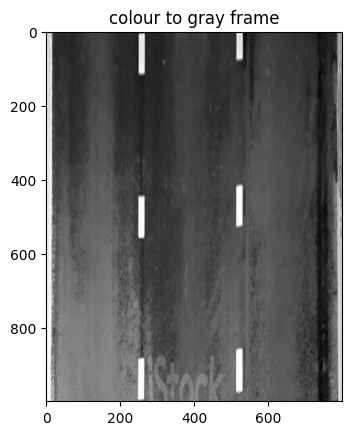

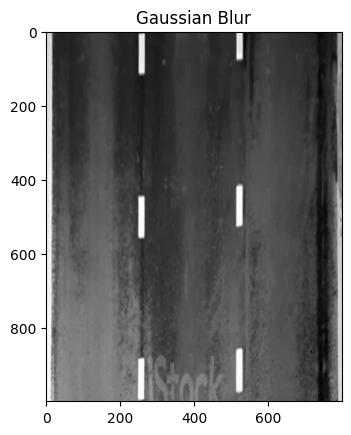

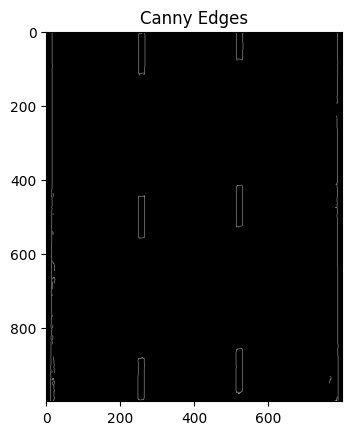

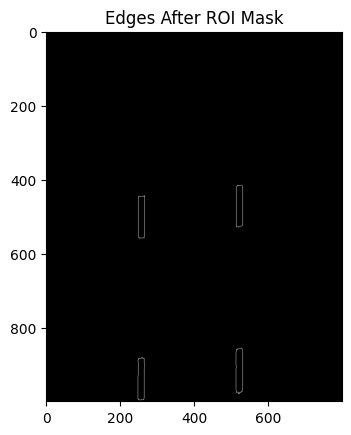

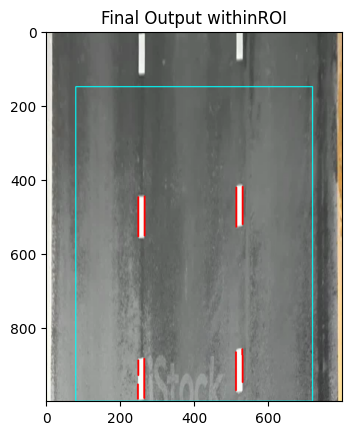

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


input_path = './bird_eye_output.mp4'
cap = cv2.VideoCapture(input_path)
if not cap.isOpened():
    raise IOError('Cannot open video file')

ret, frame = cap.read()
if not ret:
    raise IOError('Cannot read video frame')

# ROI
h, w = frame.shape[:2]
top_margin = int(0.15 * h)
bottom_margin = int(0.0 * h)
left_margin = int(0.1 * w)
right_margin = int(0.1 * w)

x_min = left_margin
x_max = w - right_margin
y_min = top_margin
y_max = h - bottom_margin

plt.figure()
plt.title("Original Frame")
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
plt.figure()
plt.title("colour to gray frame")
plt.imshow(gray, cmap='gray')
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plt.figure()
plt.title("Gaussian Blur")
plt.imshow(blurred, cmap='gray')
edges = cv2.Canny(blurred, 50, 150)
plt.figure()
plt.title("Canny Edges")
plt.imshow(edges, cmap='gray')

roi_mask = np.zeros((h, w), dtype=np.uint8)
cv2.rectangle(roi_mask, (x_min, y_min), (x_max, y_max), 255, thickness=-1)
masked_edges = cv2.bitwise_and(edges, roi_mask)
plt.figure()
plt.title("Edges After ROI Mask")
plt.imshow(masked_edges, cmap='gray')

lines = cv2.HoughLinesP(masked_edges, 1, np.pi / 180, threshold=30,
                        minLineLength=20, maxLineGap=20)

output = frame.copy()
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x_min <= x1 <= x_max and x_min <= x2 <= x_max and \
                y_min <= y1 <= y_max and y_min <= y2 <= y_max:
            angle = np.arctan2((y2 - y1), (x2 - x1)) * 180 / np.pi
            if 20 < abs(angle) < 160:
                cv2.line(output, (x1, y1), (x2, y2), (0, 0, 255), 3)

# ROI boundary
cv2.rectangle(output, (x_min, y_min), (x_max, y_max), (255, 255, 0), 2)

plt.figure()
plt.title("Final Output withinROI")
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))

plt.show()


This One Transforms the video into 2D. Irrespective of  Scale and saves in a new file

In [11]:
import cv2
import numpy as np

# Global variables
points = []
selection_complete = False


def click_event(event, x, y, flags, param):
    global points, selection_complete
    if event == cv2.EVENT_LBUTTONDOWN and len(points) < 4:
        points.append((x, y))
        cv2.circle(frame, (x, y), 5, (0, 255, 0), -1)
        cv2.imshow("Select 4 Points (then press SPACE)", frame)
        if len(points) == 4:
            selection_complete = True


# Open video file
input_video = "/Users/opb/PycharmProjects/LaneDetection/inputVideo/highway.mp4"
cap = cv2.VideoCapture(input_video)

# Get first frame for point selection
ret, frame = cap.read()
if not ret:
    print("Error reading video file")
    exit()

# Let user select points on first frame
cv2.imshow("Select 4 Points (then press SPACE)", frame)
cv2.setMouseCallback("Select 4 Points (then press SPACE)", click_event)

while not selection_complete:
    key = cv2.waitKey(1) & 0xFF
    if key == ord(' ') or cv2.getWindowProperty("Select 4 Points (then press SPACE)", cv2.WND_PROP_VISIBLE) < 1:
        break

cv2.destroyAllWindows()

if len(points) != 4:
    print("Error: Need exactly 4 points")
    exit()

# Calculate destination points based on first frame
src_pts = np.float32(points)
width = int(max(np.linalg.norm(src_pts[0] - src_pts[1]), np.linalg.norm(src_pts[2] - src_pts[3])))
height = int(max(np.linalg.norm(src_pts[0] - src_pts[3]), np.linalg.norm(src_pts[1] - src_pts[2])))
dst_pts = np.float32([[0, 0], [width, 0], [width, height], [0, height]])

# Set up video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_video = "output_transformed.mp4"
out = cv2.VideoWriter(output_video, fourcc, 30.0, (width, height))

# Process all frames
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)  # Rewind to first frame
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Get perspective transform matrix
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)

    # Warp perspective
    transformed = cv2.warpPerspective(frame, M, (width, height))

    # Write frame to output video
    out.write(transformed)

    # Display
    cv2.imshow("Transformed Video", transformed)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Clean up
cap.release()
out.release()
cv2.destroyAllWindows()
print(f"Transformed video saved to {output_video}")

Transformed video saved to output_transformed.mp4


This one gets the four coordinatEs required to determine real-world coordinates from the image coordinates.

Coordinates of Pixel Locator.

In [12]:
import cv2


def select_8_points_from_video(video_path, frame_number=0):
    # Open the video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Cannot open video.")
        return

    # Go to specific frame (default = first frame)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    if not ret:
        print("Error: Cannot read frame.")
        return

    frame = cv2.resize(frame, (1280, 720))  # Optional resize for visibility

    points = []

    def click_event(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN and len(points) < 8:
            points.append((x, y))
            cv2.circle(frame, (x, y), 5, (0, 0, 255), -1)
            cv2.putText(frame, f"{len(points)}", (x + 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            cv2.imshow("Click 8 Points", frame)

    print("ℹ️ Click on 8 points in the image window...")
    cv2.imshow("Click 8 Points", frame)
    cv2.setMouseCallback("Click 8 Points", click_event)

    while len(points) < 8:
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cv2.destroyAllWindows()

    print("\n📍 Selected Points:")
    for i, pt in enumerate(points, 1):
        print(f"Point {i}: {pt}")

    return points



video_path = "/Users/opb/PycharmProjects/LaneDetection/bird_eye_output_traffic.mp4"
select_8_points_from_video(video_path)


ℹ️ Click on 8 points in the image window...


KeyboardInterrupt: 

Speed Estimation and Kalman Filter

In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
from sort import Sort
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.ndimage import gaussian_filter1d

# Calibration parameters
PIXELS_PER_METER = 9.6  # Adjust based on your camera setup
FPS = 30
MIN_SPEED_THRESHOLD = 2.0  # km/h (ignore speeds below this)
MAX_SPEED_THRESHOLD = 120.0  # km/h (ignore speeds above this)

# Load YOLOv8 model
model = YOLO("yolov8n.pt")

# Initialize tracker with longer memory
tracker = Sort(max_age=15, min_hits=3, iou_threshold=0.3)

# Store object history with enhanced data structure
object_history = defaultdict(lambda: {
    'positions': [],
    'speeds': [],
    'smoothed_speeds': [],
    'frames': [],
    'color': tuple(np.random.randint(0, 255, 3).tolist())
})

# Speed analysis variables
speed_analysis = {
    'all_speeds': [],
    'frame_speeds': defaultdict(list),
    'vehicle_count': 0
}

# Open video
cap = cv2.VideoCapture('./bird_eye_output_traffic.mp4')

# Video writer setup
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output_with_speeds.mp4', fourcc, FPS,
                      (int(cap.get(3)), int(cap.get(4))))


# Kalman Filter for speed smoothing
class SpeedKalmanFilter:
    def __init__(self, process_noise=1e-3, measurement_noise=4):
        self.x = 0  # Speed estimate
        self.P = 1  # Estimation error covariance
        self.Q = process_noise  # Process noise
        self.R = measurement_noise  # Measurement noise

    def update(self, measurement):
        # Prediction
        self.P += self.Q

        # Kalman gain
        K = self.P / (self.P + self.R)

        # Update
        self.x += K * (measurement - self.x)
        self.P *= (1 - K)

        return self.x


# Create dictionary to store Kalman filters for each vehicle
kalman_filters = defaultdict(lambda: SpeedKalmanFilter())

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_num = int(cap.get(cv2.CAP_PROP_POS_FRAMES))

    # Detect vehicles
    results = model(frame)[0]
    detections = []
    for r in results.boxes.data.tolist():
        x1, y1, x2, y2, conf, cls = r
        if int(cls) in [2, 3, 5, 7]:  # Cars, motorcycles, buses, trucks
            detections.append([x1, y1, x2, y2, conf])

    dets = np.array(detections) if detections else np.empty((0, 5))

    # Update tracker with current detections
    tracks = tracker.update(dets)

    # Process each tracked object
    for track in tracks:
        x1, y1, x2, y2, track_id = track
        cx, cy = (x1 + x2) / 2, (y1 + y2) / 2
        w, h = x2 - x1, y2 - y1

        # Initialize vehicle data if new
        if track_id not in object_history:
            speed_analysis['vehicle_count'] += 1

        # Get position history
        history = object_history[track_id]
        history['positions'].append((cx, cy))
        history['frames'].append(frame_num)

        # Calculate speed if enough history exists
        if len(history['positions']) > 1:
            # Calculate distance moved (in meters)
            prev_cx, prev_cy = history['positions'][-2]
            dist_pixels = np.sqrt((cx - prev_cx) ** 2 + (cy - prev_cy) ** 2)
            dist_meters = dist_pixels / PIXELS_PER_METER

            # Calculate time elapsed (in hours)
            frames_elapsed = frame_num - history['frames'][-2]
            time_hours = frames_elapsed / (FPS * 3600)

            # Calculate speed in km/h
            if time_hours > 0:
                speed_kmph = (dist_meters / time_hours) / 1000

                # Apply sanity checks
                if MIN_SPEED_THRESHOLD <= speed_kmph <= MAX_SPEED_THRESHOLD:
                    # Apply Kalman filter
                    filtered_speed = kalman_filters[track_id].update(speed_kmph)
                    history['speeds'].append(speed_kmph)
                    history['smoothed_speeds'].append(filtered_speed)

                    # Store for overall analysis
                    speed_analysis['all_speeds'].append(filtered_speed)
                    speed_analysis['frame_speeds'][frame_num].append(filtered_speed)
                else:
                    history['speeds'].append(np.nan)
                    history['smoothed_speeds'].append(np.nan)
            else:
                history['speeds'].append(np.nan)
                history['smoothed_speeds'].append(np.nan)
        else:
            history['speeds'].append(np.nan)
            history['smoothed_speeds'].append(np.nan)

        # Get color for this vehicle
        color = object_history[track_id]['color']

        # Draw bounding box and info
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)

        # Display current and average speed if available
        display_text = f"ID {int(track_id)}"
        if len(history['smoothed_speeds']) > 0 and not np.isnan(history['smoothed_speeds'][-1]):
            current_speed = history['smoothed_speeds'][-1]
            display_text += f" | {current_speed:.1f} km/h"

            # Calculate and display average speed if we have enough data
            valid_speeds = [s for s in history['smoothed_speeds'] if not np.isnan(s)]
            if len(valid_speeds) > 5:
                avg_speed = np.mean(valid_speeds)
                display_text += f" | Avg: {avg_speed:.1f} km/h"

        cv2.putText(frame, display_text, (int(x1), int(y1) - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    # Display frame info
    cv2.putText(frame, f"Frame: {frame_num}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)
    cv2.putText(frame, f"Vehicles: {len(tracks)}", (10, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)

    # Write frame to output video
    out.write(frame)

    cv2.imshow("Multi-Vehicle Speed Tracker", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()


# Post-processing analysis and visualization
def smooth_speeds(speeds, window_size=5):
    """Apply smoothing to speed data"""
    if len(speeds) < window_size:
        return speeds
    return gaussian_filter1d([s if not np.isnan(s) else 0 for s in speeds],
                             sigma=1.5)


# Plot individual vehicle speeds
plt.figure(figsize=(15, 8))
for track_id, data in object_history.items():
    if len(data['smoothed_speeds']) > 5:  # Only plot vehicles with sufficient data
        smoothed = smooth_speeds(data['smoothed_speeds'])
        plt.plot(data['frames'], smoothed,
                 label=f'Vehicle {int(track_id)}',
                 color=np.array(data['color']) / 255)

plt.title("Vehicle Speed vs Frame Number")
plt.xlabel("Frame Number")
plt.ylabel("Speed (km/h)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('individual_speeds.png', bbox_inches='tight')
plt.show()

# Plot speed distribution
plt.figure(figsize=(10, 6))
plt.hist([s for s in speed_analysis['all_speeds'] if not np.isnan(s)], bins=20)
plt.title("Speed Distribution of All Vehicles")
plt.xlabel("Speed (km/h)")
plt.ylabel("Frequency")
plt.grid(True)
plt.savefig('speed_distribution.png')
plt.show()

# Plot frame-by-frame average speed
frame_numbers = sorted(speed_analysis['frame_speeds'].keys())
avg_speeds = [np.mean(speed_analysis['frame_speeds'][f]) for f in frame_numbers]
plt.figure(figsize=(10, 6))
plt.plot(frame_numbers, avg_speeds)
plt.title("Average Speed per Frame")
plt.xlabel("Frame Number")
plt.ylabel("Average Speed (km/h)")
plt.grid(True)
plt.savefig('average_speeds.png')
plt.show()

# Print summary statistics
valid_speeds = [s for s in speed_analysis['all_speeds'] if not np.isnan(s)]
print("\nSpeed Analysis Summary:")
print(f"Total vehicles tracked: {speed_analysis['vehicle_count']}")
print(f"Mean speed: {np.mean(valid_speeds):.2f} km/h")
print(f"Median speed: {np.median(valid_speeds):.2f} km/h")
print(f"Standard deviation: {np.std(valid_speeds):.2f} km/h")
print(f"Maximum speed: {np.max(valid_speeds):.2f} km/h")
print(f"Minimum speed: {np.min(valid_speeds):.2f} km/h")


0: 640x512 4 cars, 1 bus, 4 trucks, 164.8ms
Speed: 19.4ms preprocess, 164.8ms inference, 13.8ms postprocess per image at shape (1, 3, 640, 512)


Kalman Filter (Generic)

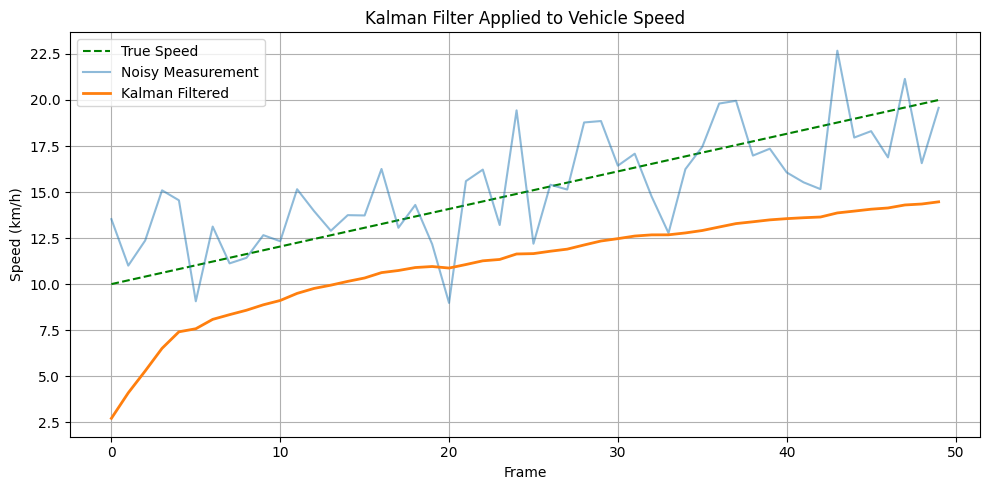

In [1]:
import numpy as np
import matplotlib.pyplot as plt


class KalmanFilter1D:
    def __init__(self, process_variance, measurement_variance):
        self.x = 0  # Initial state (speed)
        self.P = 1  # Initial estimation covariance
        self.Q = process_variance  # Process variance
        self.R = measurement_variance  # Measurement variance

    def update(self, measurement):
        # Prediction step
        self.P = self.P + self.Q

        # Kalman gain
        K = self.P / (self.P + self.R)

        # Update step
        self.x = self.x + K * (measurement - self.x)
        self.P = (1 - K) * self.P

        return self.x


# Simulate noisy speed data for one vehicle
np.random.seed(0)
true_speeds = np.linspace(10, 20, 50)  # Simulated true speeds from 10 to 20 km/h
noisy_speeds = true_speeds + np.random.normal(0, 2, size=true_speeds.shape)  # Add noise

# Apply Kalman Filter
kf = KalmanFilter1D(process_variance=1e-3, measurement_variance=4)
filtered_speeds = [kf.update(z) for z in noisy_speeds]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(true_speeds, label='True Speed', linestyle='--', color='green')
plt.plot(noisy_speeds, label='Noisy Measurement', alpha=0.5)
plt.plot(filtered_speeds, label='Kalman Filtered', linewidth=2)
plt.title('Kalman Filter Applied to Vehicle Speed')
plt.xlabel('Frame')
plt.ylabel('Speed (km/h)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Part 2: Damage Assessment using Pre and Post attack captured images**

Applying SIFT(Scale Invariant Feature Transform)

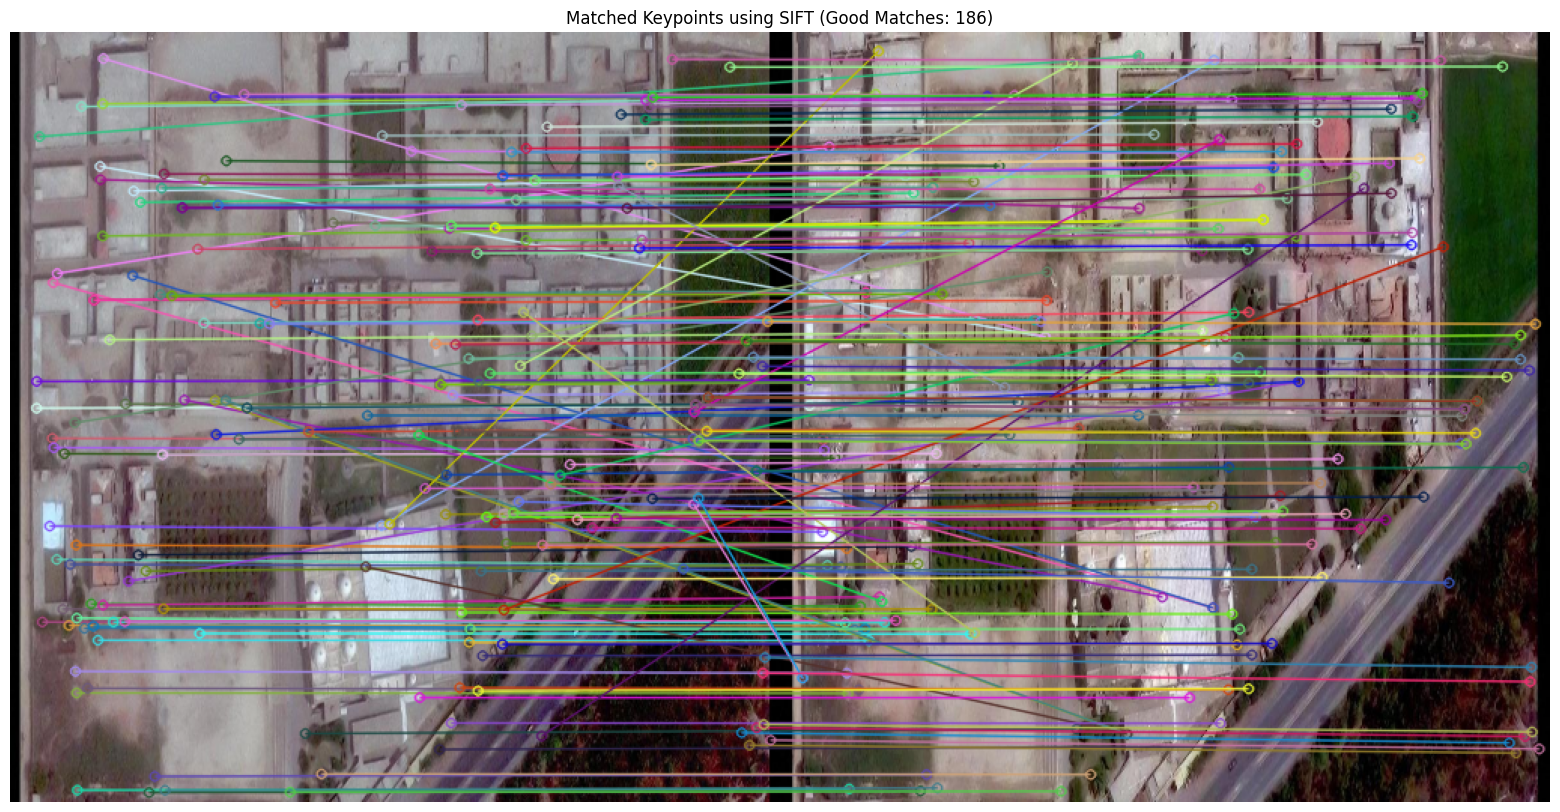

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read images
before = cv2.imread("/Users/opb/PycharmProjects/LaneDetection/Images/1.jpeg")
after = cv2.imread("/Users/opb/PycharmProjects/LaneDetection/Images/2.jpeg")

# Resize for consistency
before = cv2.resize(before, (512, 512))
after = cv2.resize(after, (512, 512))

# Convert to grayscale
gray_before = cv2.cvtColor(before, cv2.COLOR_BGR2GRAY)
gray_after = cv2.cvtColor(after, cv2.COLOR_BGR2GRAY)

# Initialize SIFT
sift = cv2.SIFT_create()

# Detect and compute keypoints/descriptors
kp1, des1 = sift.detectAndCompute(gray_before, None)
kp2, des2 = sift.detectAndCompute(gray_after, None)

# Feature matching using FLANN
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Apply Lowe's ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Draw matches
matched_img = cv2.drawMatches(before, kp1, after, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Visualize
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
plt.title(f"Matched Keypoints using SIFT (Good Matches: {len(good_matches)})")
plt.axis('off')
plt.show()


Detecting the damage after SIFT

Damaged percentage: 25.64%


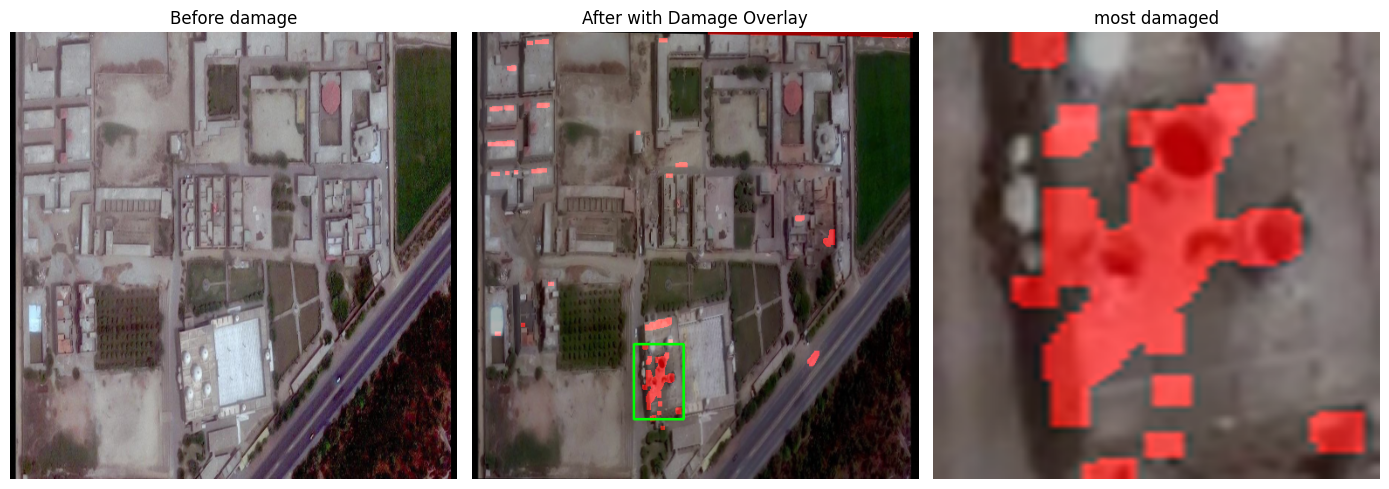

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read images
before = cv2.imread("/Users/opb/PycharmProjects/LaneDetection/Images/1.jpeg")
after = cv2.imread("/Users/opb/PycharmProjects/LaneDetection/Images/2.jpeg")
before = cv2.resize(before, (512, 512))
after = cv2.resize(after, (512, 512))

# Grayscale
before_gray = cv2.cvtColor(before, cv2.COLOR_BGR2GRAY)
after_gray = cv2.cvtColor(after, cv2.COLOR_BGR2GRAY)

# --- SIFT + Alignment ---
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(before_gray, None)
kp2, des2 = sift.detectAndCompute(after_gray, None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)
good = [m for m, n in matches if m.distance < 0.75 * n.distance]

src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

H, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
after_aligned = cv2.warpPerspective(after, H, (512, 512))

# --- Difference Mask ---
before_blur = cv2.GaussianBlur(before_gray, (5, 5), 0)
after_blur = cv2.GaussianBlur(cv2.cvtColor(after_aligned, cv2.COLOR_BGR2GRAY), (5, 5), 0)
diff = cv2.absdiff(before_blur, after_blur)
_, damage_mask = cv2.threshold(diff, 55, 255, cv2.THRESH_BINARY)
damage_mask = cv2.morphologyEx(damage_mask, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8))

# --- Red Overlay for Damage ---
damage_color = np.zeros_like(after_aligned)
damage_color[:, :] = (0, 0, 255)
mask_rgb = cv2.cvtColor(damage_mask, cv2.COLOR_GRAY2BGR)
red_overlay = cv2.bitwise_and(damage_color, mask_rgb)
marked_after = cv2.addWeighted(after_aligned, 0.7, red_overlay, 0.6, 0)

# --- ROI Extraction: Most Damaged Region ---
contours, _ = cv2.findContours(damage_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if contours:
    max_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(max_contour)

    # Expand ROI slightly
    pad = 10
    x = max(x - pad, 0)
    y = max(y - pad, 0)
    w = min(w + 2 * pad, 512 - x)
    h = min(h + 2 * pad, 512 - y)

    # Crop and zoom ROI
    roi_zoom = cv2.resize(marked_after[y:y + h, x:x + w], (300, 300), interpolation=cv2.INTER_CUBIC)

    # Damage percentage in ROI
    roi_damage_mask = damage_mask[y:y + h, x:x + w]
    total_roi_pixels = roi_damage_mask.size
    damaged_pixels = cv2.countNonZero(roi_damage_mask)
    damage_percentage = (damaged_pixels / total_roi_pixels) * 100
    print(f"Damaged percentage: {damage_percentage:.2f}%")

    # Draw rectangle on full image
    roi_marked = marked_after.copy()
    cv2.rectangle(roi_marked, (x, y), (x + w, y + h), (0, 255, 0), 2)
    # cv2.putText(roi_marked, f"{damage_percentage:.1f}%", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,255), 2)

else:
    print(" No damage detected.")
    roi_zoom = np.zeros((300, 300, 3), dtype=np.uint8)
    roi_marked = marked_after.copy()

# --- Plotting ---
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plt.title("Before damage")
plt.imshow(cv2.cvtColor(before, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("After with Damage Overlay")
plt.imshow(cv2.cvtColor(roi_marked, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("most damaged")
plt.imshow(cv2.cvtColor(roi_zoom, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()


**Part 3: Surveillance Using CCTV footage**

Detection of Numberplates(From images)

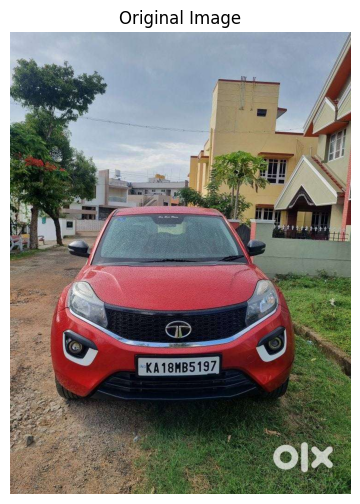

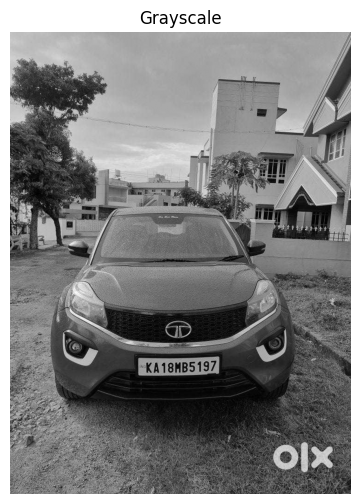

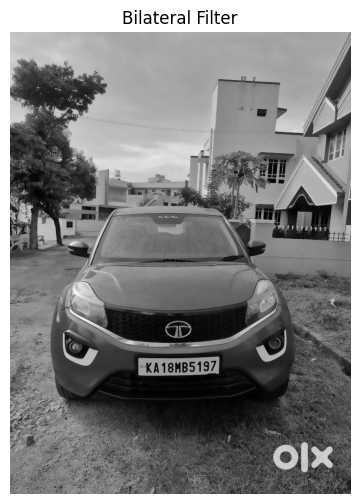

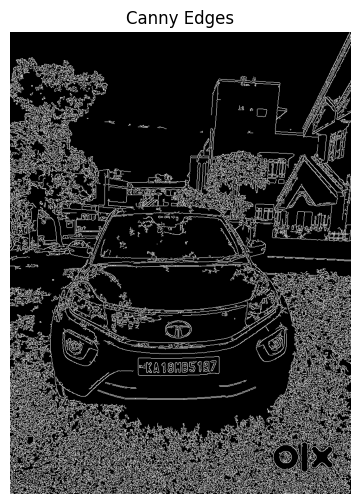

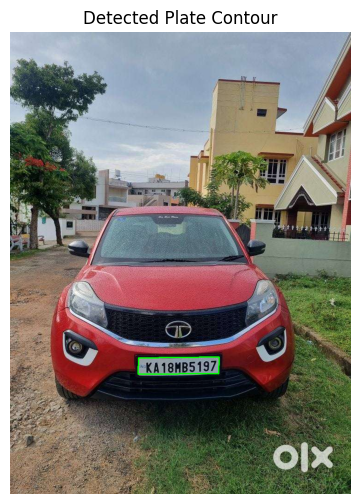

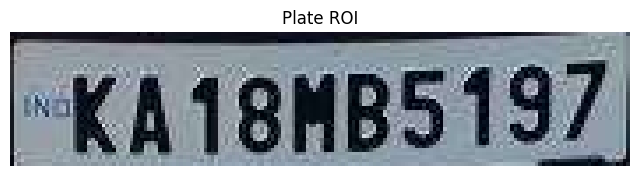

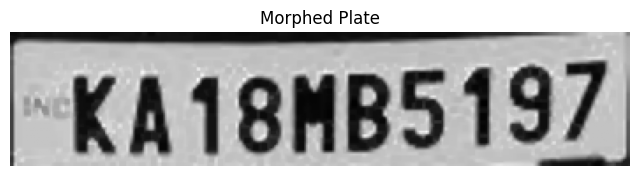

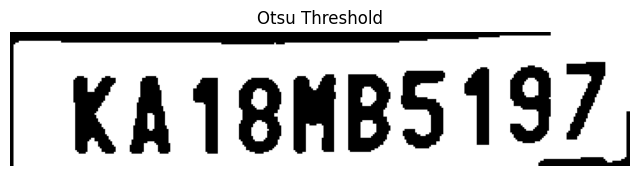

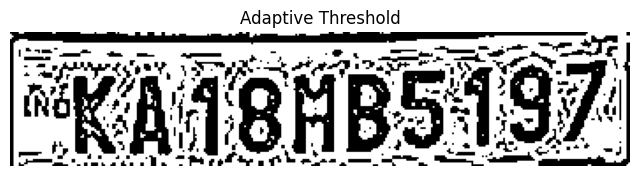

Using CPU. Note: This module is much faster with a GPU.


Detected Number Plate:  KA18MB5197
🧠 EasyOCR: KA18HB5197 (conf: 0.75)

Final Detected Plate: KA18MB5197


/Users/opb/PycharmProjects/LaneDetection/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [4]:
import cv2
import pytesseract
import matplotlib.pyplot as plt
import numpy as np
import easyocr
import re

# Set Tesseract path (if needed)
pytesseract.pytesseract.tesseract_cmd = "/opt/homebrew/bin/tesseract"  # Change if on Windows


# Show images
def show(title, img, cmap='gray'):
    plt.figure(figsize=(8, 6))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()


# Validate license plate format (example: Indian format)
def is_valid_plate(text):
    text = re.sub(r'[^A-Z0-9]', '', text)
    return bool(re.match(r'^[A-Z]{2}[0-9]{2}[A-Z]{0,2}[0-9]{4}$', text))


# Load and preprocess image
image_path = "image.jpeg"
#image_path = "/content/Skoda-Superb-BW-India.jpg"  # Change to your image
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
show("Original Image", img_rgb, cmap=None)

# Grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
show("Grayscale", gray)

# Bilateral filtering
filtered = cv2.bilateralFilter(gray, 11, 17, 17)
show("Bilateral Filter", filtered)

# Canny Edge Detection
edges = cv2.Canny(filtered, 30, 200)
show("Canny Edges", edges)

# Find contours
contours, _ = cv2.findContours(edges.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:30]

plate_contour = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 0.018 * cv2.arcLength(contour, True), True)
    if len(approx) == 4:
        plate_contour = approx
        break

if plate_contour is not None:
    # Draw contour
    plate_img = img_rgb.copy()
    cv2.drawContours(plate_img, [plate_contour], -1, (0, 255, 0), 2)
    show("Detected Plate Contour", plate_img, cmap=None)

    # Crop plate
    x, y, w, h = cv2.boundingRect(plate_contour)
    plate_roi = gray[y:y + h, x:x + w]
    plate_color = img_rgb[y:y + h, x:x + w]
    show("Plate ROI", plate_color, cmap=None)

    # Resize for better OCR
    resized = cv2.resize(plate_roi, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)

    # Morphology to close gaps
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    morphed = cv2.morphologyEx(resized, cv2.MORPH_CLOSE, kernel)
    show("Morphed Plate", morphed)

    # Threshold (Otsu)
    _, thresh_otsu = cv2.threshold(morphed, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    show("Otsu Threshold", thresh_otsu)

    # Adaptive threshold (alternative)
    adaptive_thresh = cv2.adaptiveThreshold(
        resized, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 11, 2
    )
    show("Adaptive Threshold", adaptive_thresh)

    # -------- Tesseract OCR --------
    tess_config = r'--psm 7 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
    tess_text = pytesseract.image_to_string(thresh_otsu, config=tess_config)
    tess_cleaned = re.sub(r'[^A-Z0-9]', '', tess_text.strip().upper())
    print("Detected Number Plate: ", tess_cleaned if tess_cleaned else "Failed")

    # -------- EasyOCR --------
    reader = easyocr.Reader(['en'], gpu=False)
    easy_results = reader.readtext(resized)
    if easy_results:
        easy_text = easy_results[0][1]
        easy_conf = easy_results[0][2]
        easy_cleaned = re.sub(r'[^A-Z0-9]', '', easy_text.strip().upper())
        print(f"🧠 EasyOCR: {easy_cleaned} (conf: {easy_conf:.2f})")
    else:
        easy_cleaned = "Failed"
        easy_conf = 0.0
        print("🧠 EasyOCR: Failed")

    # -------- Final Decision --------
    final_plate = None
    if is_valid_plate(tess_cleaned):
        final_plate = tess_cleaned
    elif is_valid_plate(easy_cleaned):
        final_plate = easy_cleaned
    else:
        final_plate = tess_cleaned if len(tess_cleaned) > len(easy_cleaned) else easy_cleaned

    print("\nFinal Detected Plate:", final_plate if final_plate else "Uncertain")

else:
    print("License plate contour not detected.")


Detect Vehicle and reads and Logs Number plates (Real-Time surveillance camera).

In [5]:
import cv2
import pytesseract
import easyocr
import re
import csv
import os
from datetime import datetime
from ultralytics import YOLO

# Initialize models
model = YOLO("yolov8n.pt")  # Vehicle detection
reader = easyocr.Reader(['en'], gpu=False)  # Plate OCR
pytesseract.pytesseract.tesseract_cmd = "/opt/homebrew/bin/tesseract"


#============================== Frame Generation From video ====================================
def frame_generator(video_path, frame_skip=20):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1

        if frame_count % frame_skip == 0:
            yield frame_count, cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    cap.release()


#==============================Detects vehicles and returns ROIs====================================
def detect_vehicles(frame):
    """Detects vehicles and returns ROIs"""
    results = model.predict(frame, classes=[2, 5, 7], conf=0.5)
    rois = []

    for box in results[0].boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
        rois.append(frame[y1:y2, x1:x2].copy())

    return rois


#=====================Processes single plate ROI and returns (text, confidence, highlighted_plate)===========================
def process_plate(plate_roi):
    # Convert to grayscale
    gray = cv2.cvtColor(plate_roi, cv2.COLOR_RGB2GRAY)
    filtered = cv2.bilateralFilter(gray, 11, 17, 17)
    edges = cv2.Canny(filtered, 30, 200)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for contour in sorted(contours, key=cv2.contourArea, reverse=True)[:5]:
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * peri, True)

        if len(approx) == 4:  # Rectangle detection
            x, y, w, h = cv2.boundingRect(approx)
            if w > 40 and h > 15:  # Minimum plate size
                # Create highlighted version (cropped plate with border)
                plate_crop = plate_roi[y:y + h, x:x + w].copy()
                cv2.rectangle(plate_crop, (0, 0), (w - 1, h - 1), (0, 255, 0), 2)  # Green border

                # OCR Processing - pass the cropped plate for OCR
                text, confidence, _ = ocr_plate(gray[y:y + h, x:x + w], plate_crop)
                return text, confidence, plate_crop

    return None, 0, None


#==============================Performs OCR on plate image====================================
def ocr_plate(plate_img, highlighted_plate=None):
    resized = cv2.resize(plate_img, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

    # Tesseract
    tess_text = pytesseract.image_to_string(
        resized,
        config='--psm 8 --oem 3 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
    )
    tess_cleaned = re.sub(r'[^A-Z0-9]', '', tess_text.upper())

    # EasyOCR
    easy_results = reader.readtext(resized)
    easy_cleaned = re.sub(r'[^A-Z0-9]', '', easy_results[0][1].upper()) if easy_results else ""
    easy_conf = easy_results[0][2] if easy_results else 0

    # Validation and decision
    def is_valid(text):
        return bool(re.match(r'^[A-Z]{2}[0-9]{2}[A-Z]{0,2}[0-9]{4}$', text))

    if is_valid(tess_cleaned):
        return tess_cleaned, 0.95, highlighted_plate
    elif is_valid(easy_cleaned):
        return easy_cleaned, easy_conf, highlighted_plate
    elif len(tess_cleaned) >= 6:
        return tess_cleaned, 0.7, highlighted_plate
    elif len(easy_cleaned) >= 6:
        return easy_cleaned, easy_conf, highlighted_plate

    return None, 0, highlighted_plate


def log_to_csv(data, filename="plate_log.csv"):
    """Logs plate data to CSV"""
    file_exists = os.path.exists(filename)

    with open(filename, 'a' if file_exists else 'w') as f:
        writer = csv.writer(f)
        if not file_exists:
            writer.writerow(["Date", "Time", "Plate", "Confidence"])
        writer.writerow(data)


def process_video(video_path, output_csv="plate_log.csv"):
    for frame_count, frame in frame_generator(video_path, frame_skip=15):
        vehicle_rois = detect_vehicles(frame)

        for i, roi in enumerate(vehicle_rois):
            plate_text, confidence, highlighted_plate = process_plate(roi)

            if plate_text:
                timestamp = datetime.now()
                log_to_csv([
                    timestamp.strftime("%Y-%m-%d"),
                    timestamp.strftime("%H:%M:%S"),
                    plate_text,
                    f"{confidence:.2f}"
                ], output_csv)

                # Display only the highlighted plate
                if highlighted_plate is not None:
                    cv2.imshow("Detected Plate", cv2.cvtColor(highlighted_plate, cv2.COLOR_RGB2BGR))
                    key = cv2.waitKey(300)  # 300ms display or until key press
                    if key == ord('q'):  # Allow early exit with 'q'
                        cv2.destroyAllWindows()
                        return
                    cv2.destroyAllWindows()

                print(f"Frame {frame_count}: Detected plate {plate_text} (Confidence: {confidence:.2f})")


if __name__ == "__main__":
    video_file = "/Users/opb/PycharmProjects/LaneDetection/inputVideo/traffic.mp4"
    if os.path.exists(video_file):
        process_video(video_file)
    else:
        print(f"Error: Video file {video_file} not found")

Using CPU. Note: This module is much faster with a GPU.



0: 384x640 10 cars, 1 truck, 110.0ms
Speed: 19.7ms preprocess, 110.0ms inference, 16.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 82.0ms
Speed: 3.2ms preprocess, 82.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 2 trucks, 73.2ms
Speed: 2.6ms preprocess, 73.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 cars, 1 truck, 94.0ms
Speed: 2.2ms preprocess, 94.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 cars, 1 truck, 97.2ms
Speed: 2.1ms preprocess, 97.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 cars, 1 truck, 214.3ms
Speed: 4.6ms preprocess, 214.3ms inference, 11.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 cars, 118.7ms
Speed: 3.4ms preprocess, 118.7ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 94.9ms
Speed: 2.6ms preprocess, 94.9ms in

Reads the CSV log data and trains the model for learning the usual timing.

In [6]:
#+++++++This one is for synthetic data generation as live video is not available++++++

import pandas as pd
import random
from datetime import datetime, timedelta

known_plates = ['AB123CD', 'XY456ZT', 'MN789PQ', 'JK321LM', 'GH654RS']

def generate_plate(known=True):
    if known:
        return random.choice(known_plates)
    else:
        # Generate new plate (unknown)
        letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
        return (
            random.choice(letters) +
            random.choice(letters) +
            str(random.randint(100, 999)) +
            random.choice(letters) +
            random.choice(letters)
        )

def generate_vehicle_dataset(start_date, num_days, entries_per_day, include_unknown=False):
    rows = []
    for day in range(num_days):
        base_date = start_date + timedelta(days=day)
        for _ in range(entries_per_day):
            is_known = True if not include_unknown else random.random() < 0.8
            plate = generate_plate(known=is_known)
            confidence = round(random.uniform(0.7, 0.99), 2)

            # Time generation
            if is_known:
                # Mostly normal times
                hour = random.choice(range(9, 18))
            else:
                # More randomness for unknowns
                hour = random.choice([2, 3, 4, 10, 14, 23])

            minute = random.randint(0, 59)
            second = random.randint(0, 59)
            time_obj = datetime(base_date.year, base_date.month, base_date.day, hour, minute, second)

            date_str = time_obj.strftime('%Y-%m-%d')
            time_str = time_obj.strftime('%H:%M:%S')

            rows.append([date_str, time_str, plate, confidence, 'in', random.randint(1, 20)])  # direction, duration_minutes

    return pd.DataFrame(rows, columns=['date', 'time', 'plate', 'confidence', 'direction', 'duration_minutes'])

# Generate training (known vehicles only)
train_df = generate_vehicle_dataset(datetime(2025, 6, 20), num_days=5, entries_per_day=20, include_unknown=False)
train_df.to_csv("known_vehicle_data.csv", index=False)

# Generate testing (known + unknown)
test_df = generate_vehicle_dataset(datetime(2025, 6, 26), num_days=2, entries_per_day=25, include_unknown=True)
test_df.to_csv("vehicle_logs.csv", index=False)

print("Files generated:")
print("- known_vehicle_data.csv")
print("- vehicle_logs.csv")


Files generated:
- known_vehicle_data.csv
- vehicle_logs.csv


This is the model trained and detect anomaly using z-Test.

Training complete.


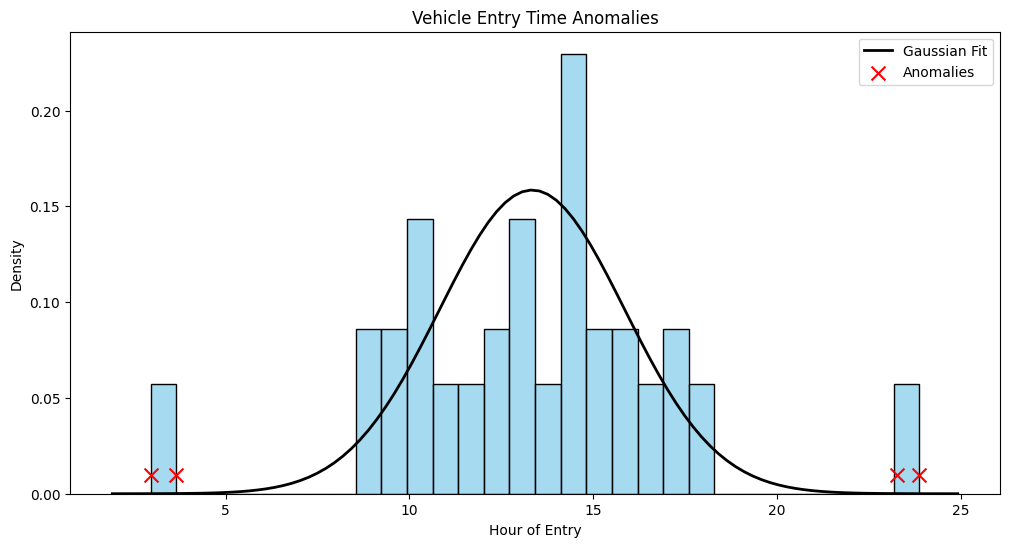

Anomalies saved to: detected_anomalies.csv


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import IsolationForest
from datetime import timedelta

# ---------- TRAINING PHASE ----------
def train_model(train_csv, alpha=0.01):
    df = pd.read_csv(train_csv)
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
    df['hour'] = df['datetime'].dt.hour + df['datetime'].dt.minute / 60

    # Train Z-score parameters
    mu, std = stats.norm.fit(df['hour'])

    # Train Isolation Forest
    clf = IsolationForest(contamination=alpha, random_state=42)
    clf.fit(df[['hour']])

    print("Training complete.")
    return mu, std, clf

# ---------- TESTING PHASE ----------
def test_model(test_csv, mu, std, clf, output_csv, alpha=0.01):
    df = pd.read_csv(test_csv)
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
    df['hour'] = df['datetime'].dt.hour + df['datetime'].dt.minute / 60

    # Anomaly detection - Z-score
    df['z_score'] = (df['hour'] - mu) / std
    df['p_value'] = 2 * (1 - stats.norm.cdf(np.abs(df['z_score'])))
    df['z_anomaly'] = df['p_value'] < alpha

    # Anomaly detection - Isolation Forest
    df['if_anomaly'] = clf.predict(df[['hour']]) == -1

    # Final anomaly decision
    df['is_anomaly'] = df['z_anomaly'] | df['if_anomaly']

    # Annotate clips
    df['clip_start'] = df['datetime'] - timedelta(seconds=5)
    df['clip_end'] = df['datetime'] + timedelta(seconds=5)

    # Save only anomaly rows
    df[df['is_anomaly']].to_csv(output_csv, index=False)

    # Plot
    plot_anomaly_distribution(df, mu, std)

    print(f"Anomalies saved to: {output_csv}")

# ---------- PLOTTING ----------
def plot_anomaly_distribution(df, mu, std):
    plt.figure(figsize=(12, 6))
    sns.histplot(df['hour'], kde=False, stat='density', color='skyblue', bins=30)
    x = np.linspace(*plt.xlim(), 100)
    plt.plot(x, stats.norm.pdf(x, mu, std), 'k', linewidth=2, label='Gaussian Fit')
    plt.scatter(df[df['is_anomaly']]['hour'], [0.01]*len(df[df['is_anomaly']]),
                color='red', label='Anomalies', s=100, marker='x')
    plt.title("Vehicle Entry Time Anomalies")
    plt.xlabel("Hour of Entry")
    plt.ylabel("Density")
    plt.legend()
    plt.savefig('vehicle_anomalies_plot.png', dpi=300)
    plt.show()

# ---------- MAIN ----------
if __name__ == "__main__":
    # Paths
    train_csv = "known_vehicle_data.csv"
    test_csv = "vehicle_logs.csv"
    output_csv = "detected_anomalies.csv"

    # Train on known behavior
    mu, std, clf = train_model(train_csv)

    # Test on new data
    test_model(test_csv, mu, std, clf, output_csv)


This Uses the Detected anomaly Vehicle timing and automatically saves the +- 5sec of the clip when the vehicle is detected.

In [ ]:
import cv2
import pandas as pd
from datetime import datetime, timedelta
import os

def extract_clips(video_path, anomaly_csv, video_start_time_str, output_dir="clips"):
    # Load anomaly data
    df = pd.read_csv(anomaly_csv)
    df['clip_start'] = pd.to_datetime(df['clip_start'])
    df['clip_end'] = pd.to_datetime(df['clip_end'])

    # Parse video start time
    video_start_time = datetime.strptime(video_start_time_str, "%Y-%m-%d %H:%M:%S")

    # Load video
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    print(f"🎥 FPS: {fps}")

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for idx, row in df.iterrows():
        clip_start = row['clip_start']
        clip_end = row['clip_end']
        start_offset = (clip_start - video_start_time).total_seconds()
        end_offset = (clip_end - video_start_time).total_seconds()

        # Frame range
        start_frame = int(start_offset * fps)
        end_frame = int(end_offset * fps)

        # Set video to start_frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
        frames_to_save = end_frame - start_frame

        # Video writer setup
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out_path = os.path.join(output_dir, f"anomaly_clip_{idx+1}.mp4")
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        out = cv2.VideoWriter(out_path, fourcc, fps, (width, height))

        print(f"Saving clip {idx+1} from {clip_start} to {clip_end} → {out_path}")

        frame_count = 0
        while cap.isOpened() and frame_count < frames_to_save:
            ret, frame = cap.read()
            if not ret:
                break
            out.write(frame)
            frame_count += 1

        out.release()

    cap.release()
    print("All anomaly clips saved.")

# Example usage
extract_clips(
    video_path="footage.mp4",
    anomaly_csv="detected_anomalies.csv",
    video_start_time_str="2025-06-29 09:00:00",
    output_dir="anomaly_clips"
)


In [1]:
import pandas as pd
import random
from datetime import datetime, timedelta
import os


def generate_plate():
    letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    return (
            random.choice(letters) +
            random.choice(letters) +
            str(random.randint(100, 999)) +
            random.choice(letters) +
            random.choice(letters)
    )


def generate_synthetic_data(start_datetime, num_records, interval_seconds=2):
    data = []
    current_time = start_datetime

    for _ in range(num_records):
        plate = generate_plate()
        confidence = round(random.uniform(0.60, 0.99), 2)
        date_str = current_time.strftime('%Y-%m-%d')
        time_str = current_time.strftime('%H:%M:%S')

        data.append([date_str, time_str, plate, confidence])
        current_time += timedelta(seconds=interval_seconds)

    df = pd.DataFrame(data, columns=['Date', 'Time', 'Plate', 'Confidence'])
    return df


# Generate data
start_time = datetime(2025, 6, 29, 9, 45, 30)
synthetic_df = generate_synthetic_data(start_time, num_records=50, interval_seconds=3)

# Save to CSV with error handling
try:
    save_path = os.path.join(os.path.expanduser("~"), "Desktop", "synthetic_vehicle_data.csv")
    synthetic_df.to_csv(save_path, index=False)
    print(f"File successfully saved to: {save_path}")
except Exception as e:
    print(f"Error saving file: {e}")

File successfully saved to: /Users/opb/Desktop/synthetic_vehicle_data.csv
